In [1]:
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# 可视化辅助函数
def visualize(h: torch.Tensor, color: any, epoch=None, loss=None):
    plt.figure(figsize=(8, 8))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")

In [3]:
from torch_geometric.datasets import KarateClub

dataset: torch.utils.data.Dataset = KarateClub()
print(f'Dataset: {dataset}：')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

c:\users\acpro\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\acpro\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\acpro\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\acpro\appd

Dataset: KarateClub()：
Number of graphs: 1
Number of features: 34
Number of classes: 2


In [4]:
# 获得第一个图对象
data = dataset[0]
# 由于现在的KarateClub没有train_mask, 所以自己加上
import numpy as np
# randint的区间[0, 2)
np_array= np.random.randint(0, 2 ,34)

mask = np_array >=1
# print(mask)
train_mask = torch.from_numpy(mask)
# 加入自动随机生成的mask
data['train_mask'] = train_mask

print(data)
print('=================================================================')

# 收集一些关于这个图数据的一些统计信息
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 18
Training node label rate: 0.53
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [5]:
# from IPython.display import Javascript # Restrict height of output cell.
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

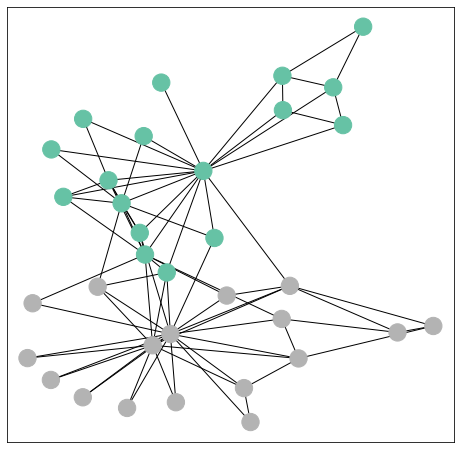

In [6]:
from torch_geometric.utils import to_networkx

G: nx.Graph = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

In [7]:
import torch
from torch.nn import Linear, Module
from torch_geometric.nn import GCNConv

class GCN(Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1: Module= GCNConv(dataset.num_features, 4)
        self.conv2: Module = GCNConv(4, 4)
        self.conv3: Module = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x: int, edge_index: int):
        h: Tensor = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh() # 最终的GNN内嵌空间

        out = self.classifier(h)
        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)


Embedding shape: [34, 2]


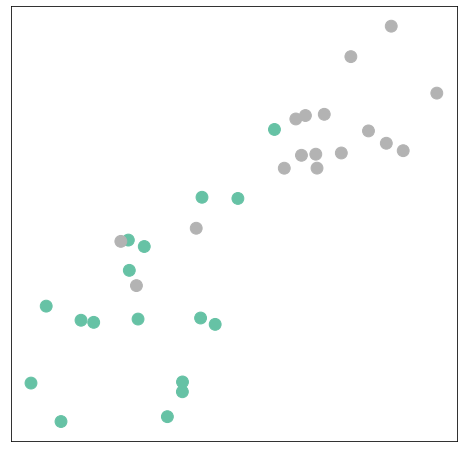

In [8]:
model = GCN()
_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

c:\users\acpro\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


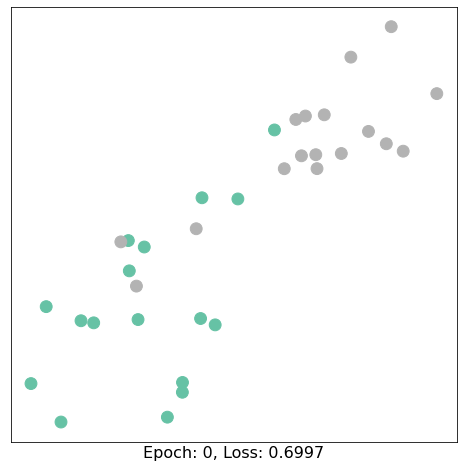

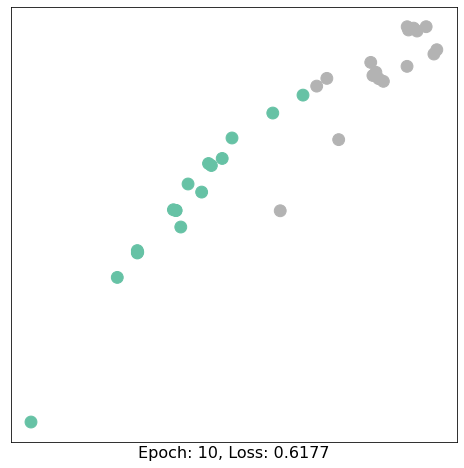

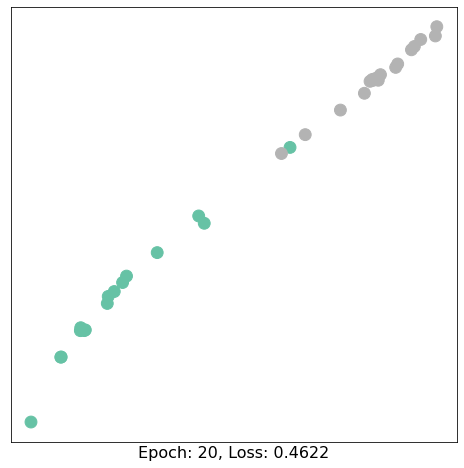

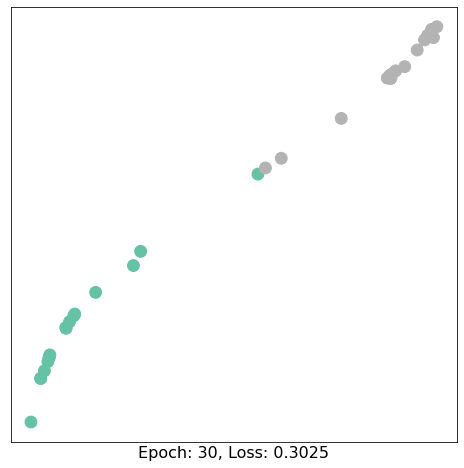

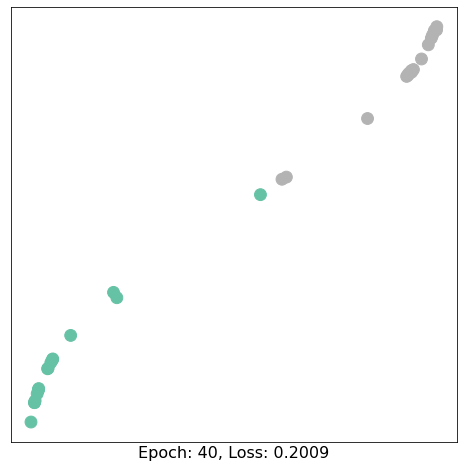

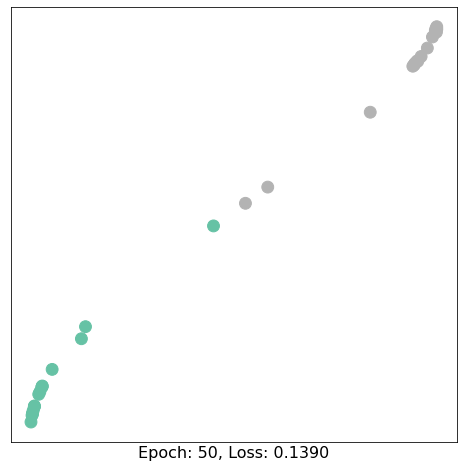

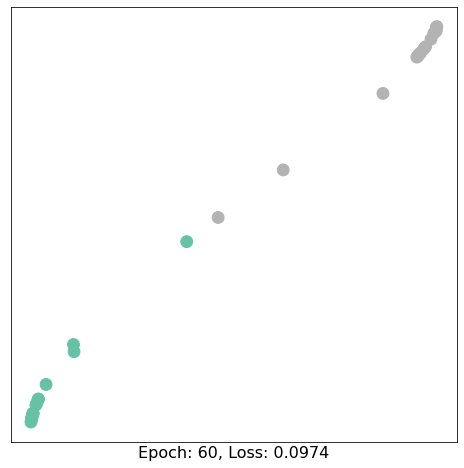

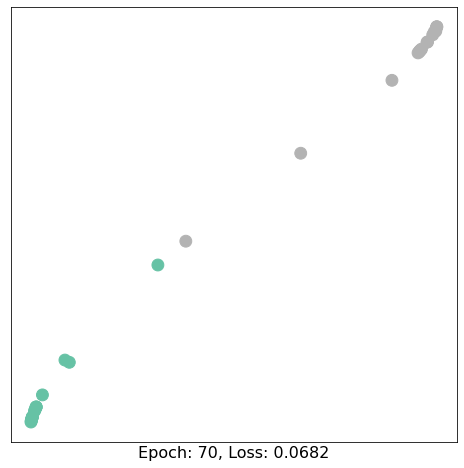

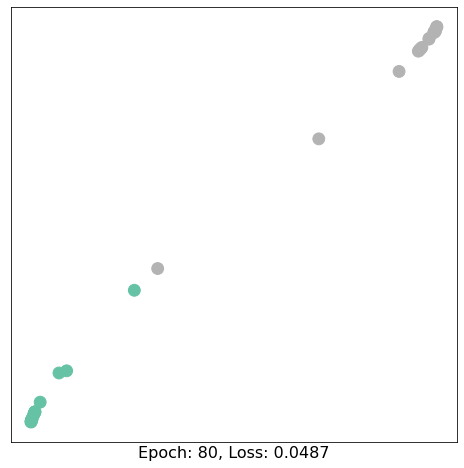

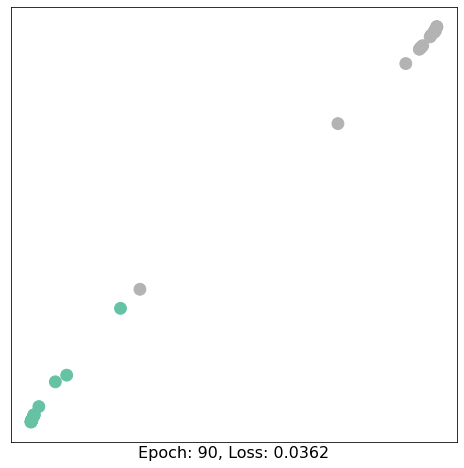

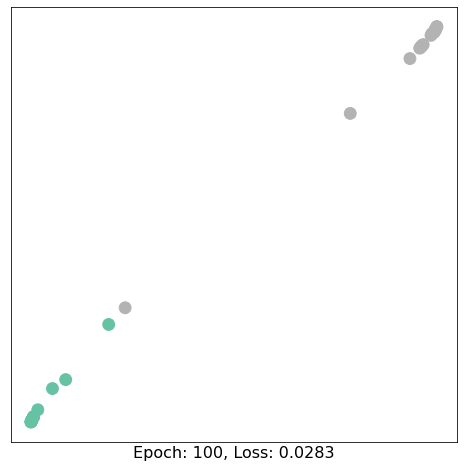

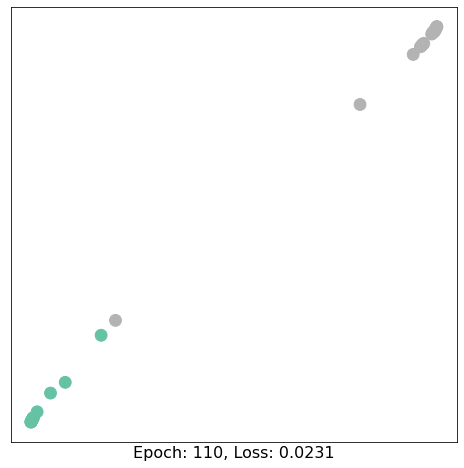

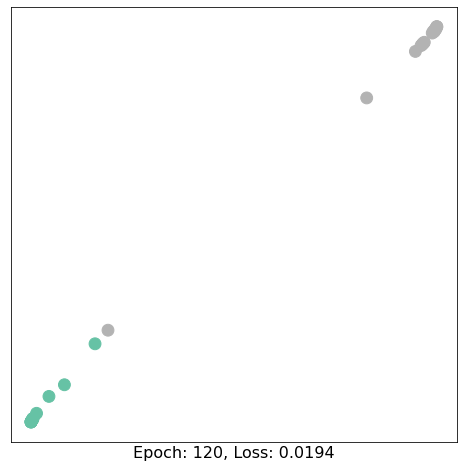

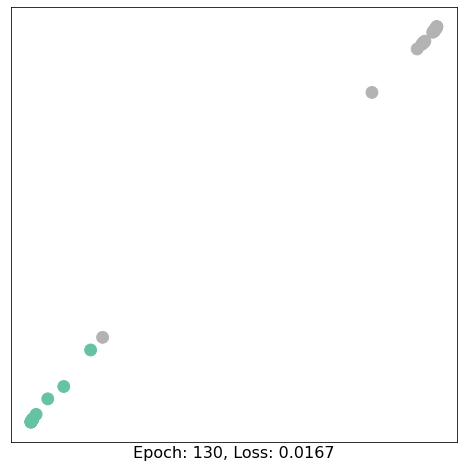

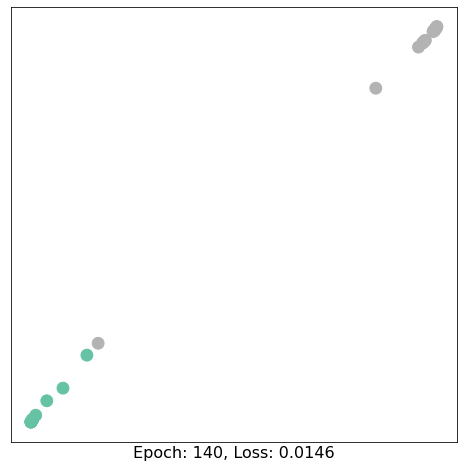

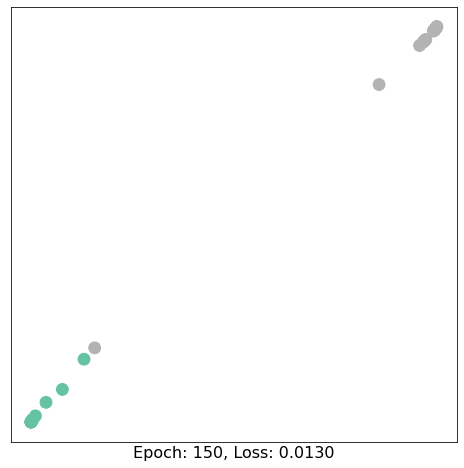

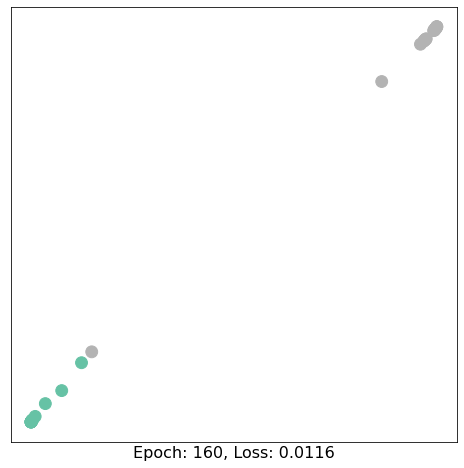

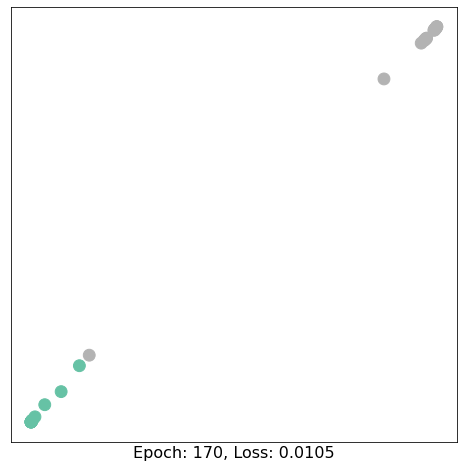

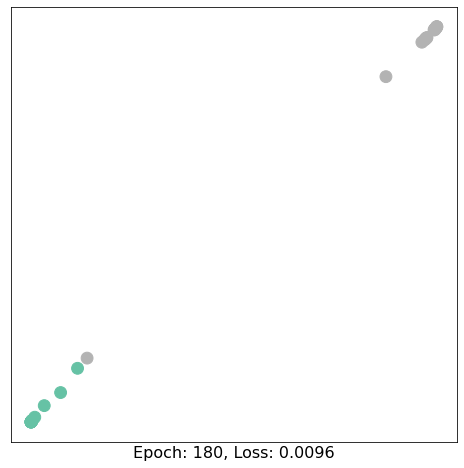

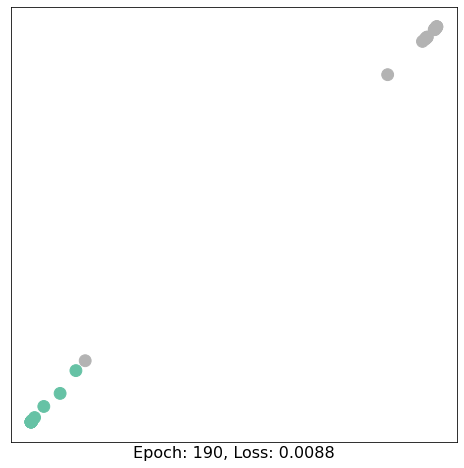

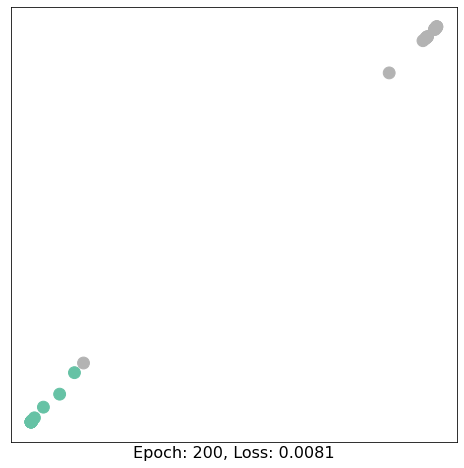

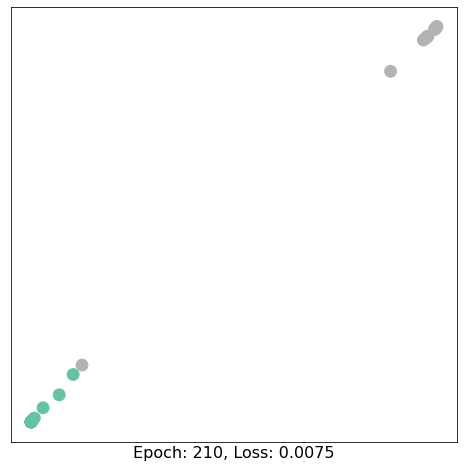

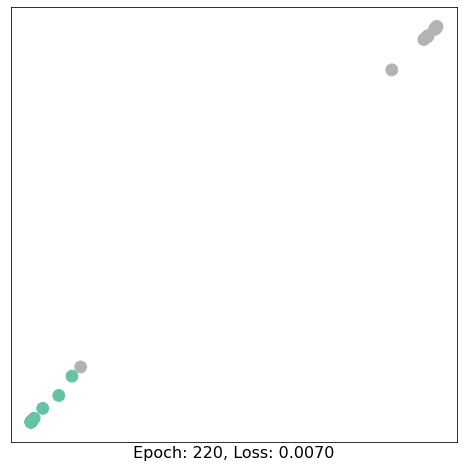

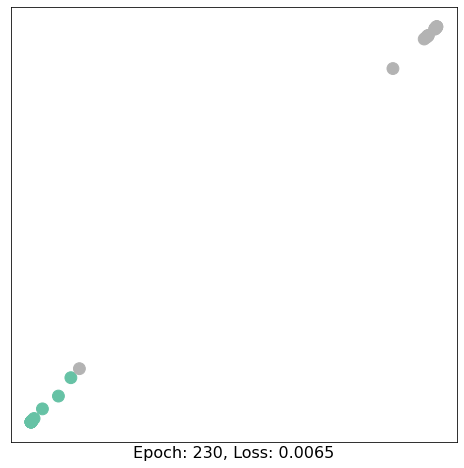

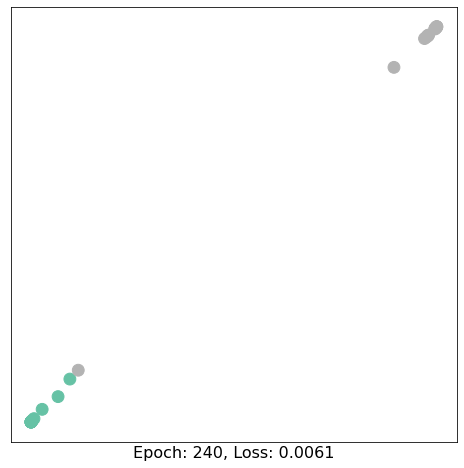

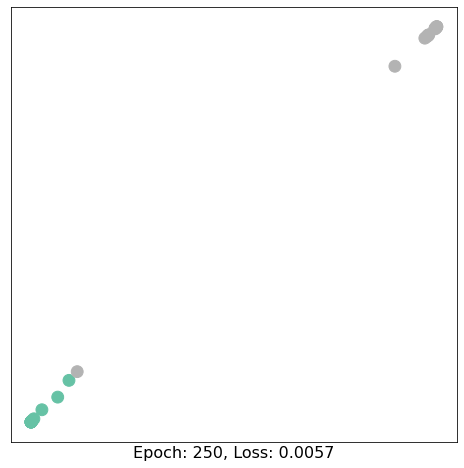

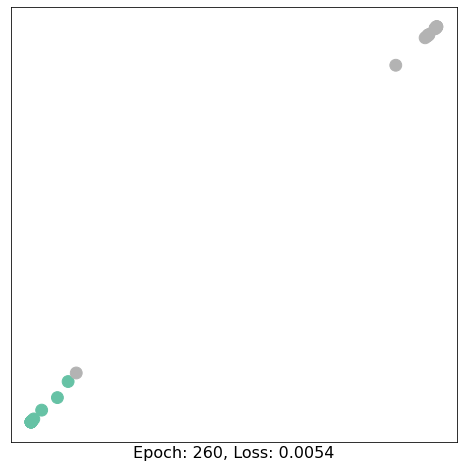

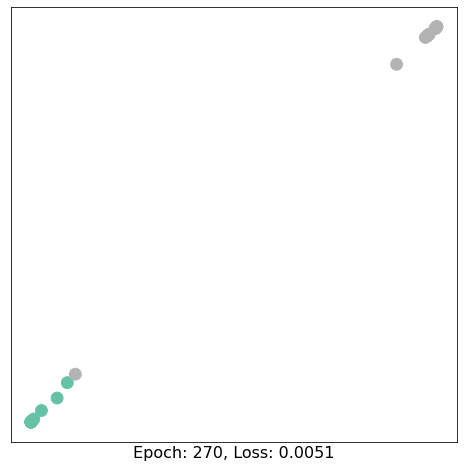

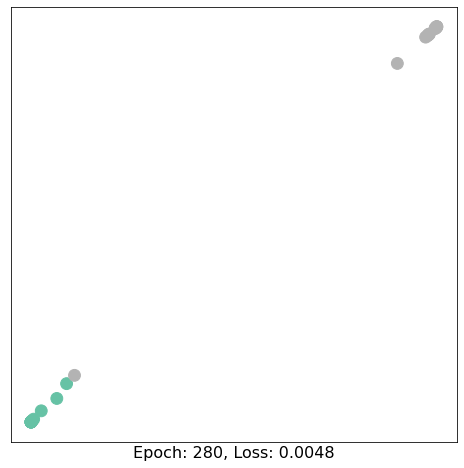

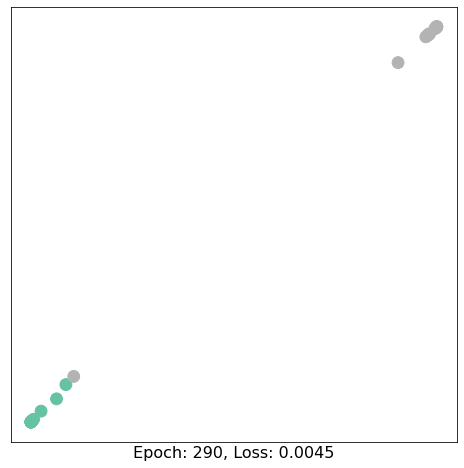

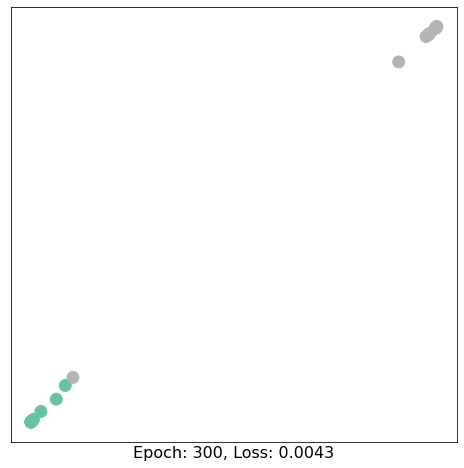

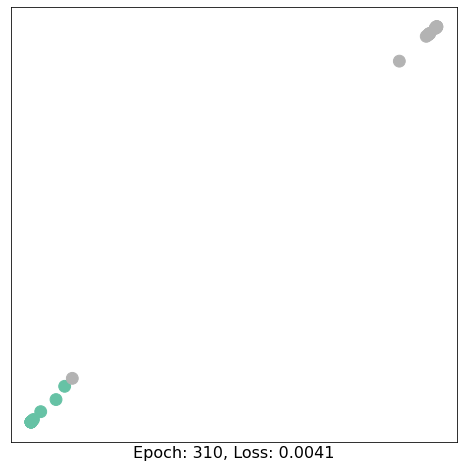

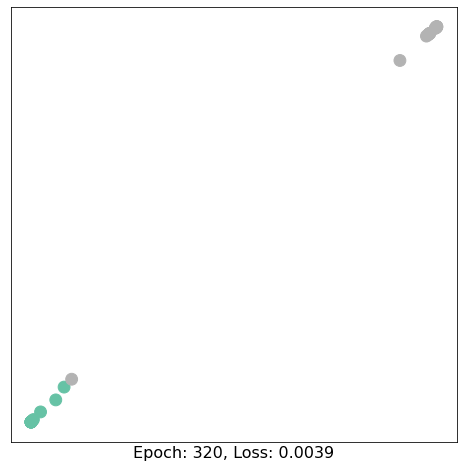

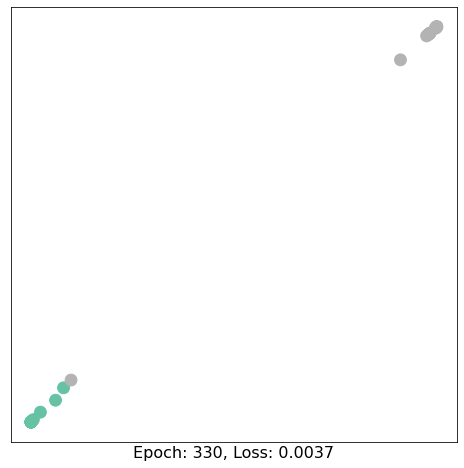

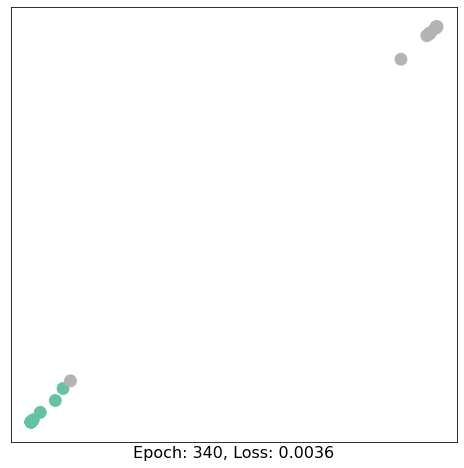

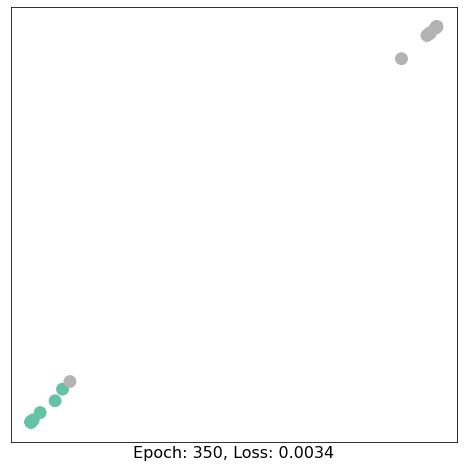

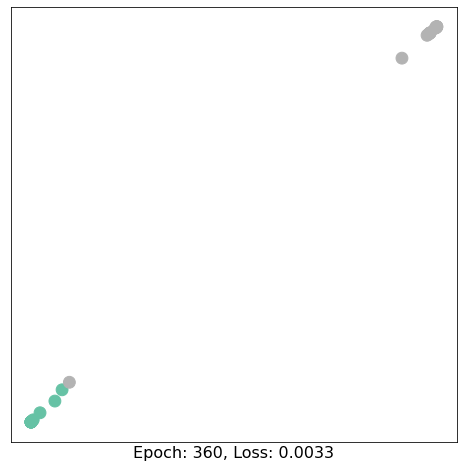

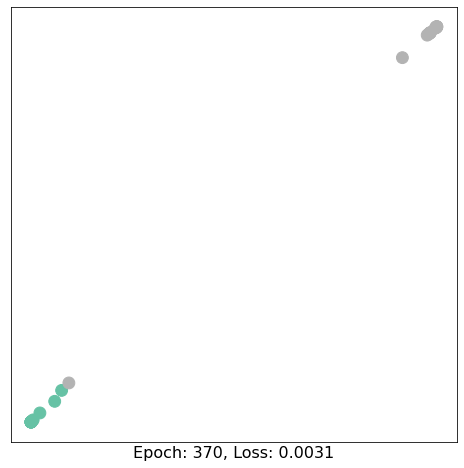

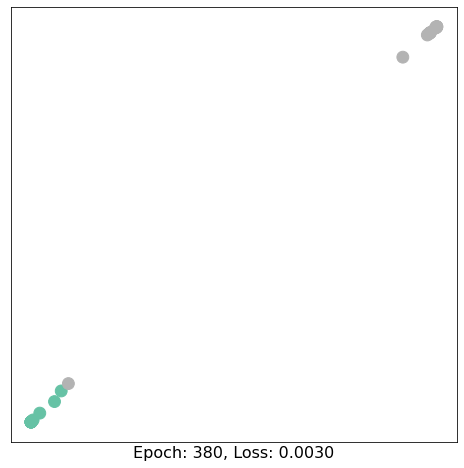

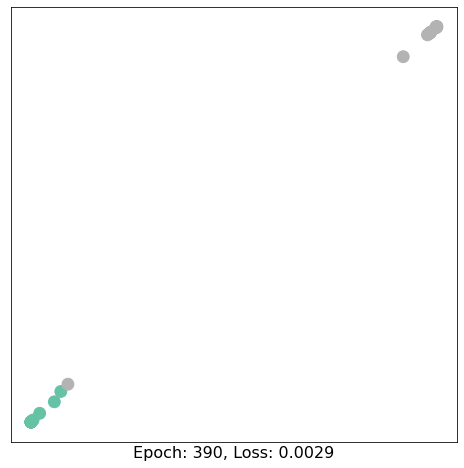

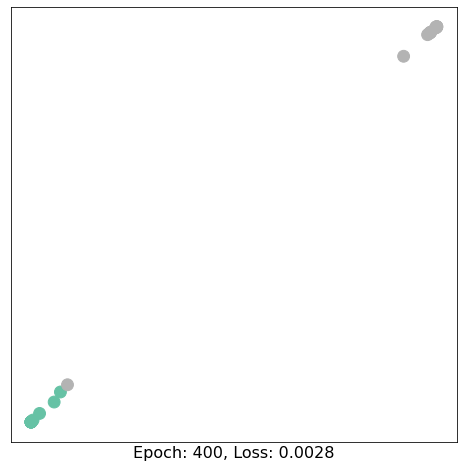

In [11]:
import time
from torch.optim import Optimizer
from torch import Tensor

model = GCN()

criterion: Module = torch.nn.CrossEntropyLoss() # 定义损失函数
optimizer: Optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # 定义优化器

def train(data: torch.utils.data.Dataset) -> (Module, Tensor):
    optimizer.zero_grad()  # 在训练过程中清空导数（梯度）
    out, h = model(data.x, data.edge_index)
    loss: Module = criterion(out[data.train_mask], data.y[data.train_mask])  # 计算损失
    loss.backward()  # 方向传播，进行梯度计算
    optimizer.step() # 基于梯度计算后的结果进行更新优化参数
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize(h ,color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)
